In [1]:
import metrics
import outputs
import confidence
import plot

import scipy
import csv
import librosa
import mir_eval
import mirdata
import pandas as pd

import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import imp
imp.reload(confidence)

<module 'confidence' from '/Users/rachelbittner/Documents/repos/continuousf0eval/notebooks/confidence.py'>

# Intro - problem illustration

/usr/local/lib/python3.7/site-packages/mir_eval/melody.py:231: UserWarning: Non-uniform timescale passed to resample_melody_series.  Pitch will be linearly interpolated, which will result in undesirable behavior if silences are indicated by missing values.  Silences should be indicated by nonpositive frequency values.
  "Non-uniform timescale passed to resample_melody_series.  Pitch "


OrderedDict([('Voicing Recall', 0.6877523553162853), ('Voicing False Alarm', 0.010256410256410256), ('Raw Pitch Accuracy', 0.6406460296096904), ('Raw Chroma Accuracy', 0.6850605652759085), ('Overall Accuracy', 0.6886993603411514)])


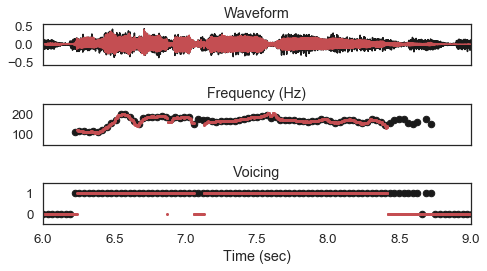

In [3]:
for tid in mirdata.ikala.track_ids():
    tid = '31139_verse'
    t1 = 6
    t2 = 9
    
    track_data = mirdata.ikala.load_track(tid)
    ref_times = track_data.f0.times + (0.032/2)
    ref_freqs = track_data.f0.frequencies

    y_vocal, fs = mirdata.ikala.load_ikala_vocal_audio(track_data)
    y_mix, fs = mirdata.ikala.load_ikala_mix_audio(track_data)

    est_times, est_freqs, est_conf = outputs.load_melodia(outputs.MELODIA[tid])
    est_freqs[est_conf < 0.5] *= -1

    scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
    print(scores)
    fig = plt.figure(figsize=(7, 4))
    sns.set(font_scale=1.2)
    sns.set_style('white')
    plt.subplot(311)
    plt.plot(np.arange(len(y_mix))/float(fs), y_mix, 'k')
    plt.plot(np.arange(len(y_vocal))/float(fs), y_vocal/2., 'r')
    plt.xlim([t1, t2])
    plt.xticks([], [])
    plt.title("Waveform")
    plt.subplot(312)
    plt.title("Frequency (Hz)")
#     plt.ylabel("Frequency (Hz)")
    plt.plot(ref_times, ref_freqs, '.k', markersize=13)
    plt.plot(est_times, est_freqs, '.r', markersize=4)
    plt.xlim([t1, t2])
    plt.xticks([], [])
    plt.ylim([50, 250])
    
    plt.subplot(313)
    plt.title("Voicing")
    plt.plot(ref_times, (ref_freqs > 0).astype(float), '.k', markersize=13)
    plt.plot(est_times, (est_freqs > 0).astype(float), '.r', markersize=4)
#     plt.plot(est_times, est_conf, '.r', markersize=4)
    plt.xlim([t1, t2])
    plt.ylim([-0.5, 1.5])

#     plt.title("Reference Frequency (Hz)")
#     plt.subplot(313)
# #     plt.title("Estimated Frequency (Hz)")
#     plt.plot(est_times, est_conf, '.r', linewidth=2)
#     plt.xlim([t1, t2])
    plt.xlabel("Time (sec)")
    
    plt.tight_layout()
    
#     fig.legend(ncol=3, loc=3, mode='expand')

    plt.tight_layout()
#     fig.subplots_adjust(bottom=0.4)

    plt.savefig("../paper-figs/intro_example.pdf", fmt='pdf', bbox_inches="tight")
    break

# 5.1 Experiments - New metrics on real data

In [4]:
SKIP = [
    'ClaraBerryAndWooldog_AirTraffic_STEM_08', 'ClaraBerryAndWooldog_Stella_STEM_07'
]

def get_scores(algorithm, dataset, threshold=0.5):
    scores_new = {}
    scores_mireval = {}
    if dataset == 'ikala':
        data = mirdata.ikala.load()
    elif dataset == 'medleydb-pitch':
        data = mirdata.medleydb_pitch.load()
    else:
        raise ValueError("invalid dataset")
        
    for tid, track_data in data.items():
        if tid in SKIP:
            continue
        
        if dataset == 'ikala':
            ref_times = track_data.f0.times + (0.032/2.0)
            ref_freqs = track_data.f0.frequencies
            ref_conf = confidence.ikala(tid)
        else:
            ref_times = track_data.pitch.times
            ref_freqs = track_data.pitch.frequencies
            ref_conf = confidence.medleydb_pitch(tid)

        if algorithm == 'deepsalience':
            est_times, est_freqs, est_conf = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])
        elif algorithm == 'melodia':
            est_times, est_freqs, est_conf = outputs.load_melodia(outputs.MELODIA[tid])
        elif algorithm == 'crepe':
            est_times, est_freqs, est_conf = outputs.load_crepe(outputs.CREPE[tid])
        elif algorithm == 'pyin':
            est_times, est_freqs, est_conf = outputs.load_pyin(outputs.PYIN[tid])
        else:
            raise ValueError("invalid algorithm")

        est_freqs_multiplier = np.ones(est_freqs.shape)
        est_freqs_multiplier[est_conf < threshold] = -1.0

        scores_new[tid] = metrics.evaluate(ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)
        scores_mireval[tid] = metrics.evaluate(
            ref_times, ref_freqs, (ref_freqs > 0).astype(float),
            est_times, est_freqs, (est_conf > threshold).astype(float))
#         scores_mireval[tid] = mir_eval.melody.evaluate(
#             ref_times, ref_freqs, est_times, est_freqs*est_freqs_multiplier)

    return scores_new, scores_mireval

In [5]:
scores_new_crepe, scores_mireval_crepe = get_scores('crepe', 'medleydb-pitch', 0.5)
scores_new_pyin, scores_mireval_pyin = get_scores('pyin', 'medleydb-pitch', 0.5)

/Users/rachelbittner/Documents/repos/continuousf0eval/notebooks/metrics.py:47: RuntimeWarning: invalid value encountered in subtract
  return np.abs(freq_diff_semitones - octave) < tolerance
/Users/rachelbittner/Documents/repos/continuousf0eval/notebooks/metrics.py:47: RuntimeWarning: invalid value encountered in less
  return np.abs(freq_diff_semitones - octave) < tolerance


In [6]:
scores_new_melodia, scores_mireval_melodia = get_scores('melodia', 'ikala', 0.5)
scores_new_deepsal, scores_mireval_deepsal = get_scores('deepsalience', 'ikala', 0.5)

/Users/rachelbittner/Documents/repos/continuousf0eval/notebooks/metrics.py:165: UserWarning: Non-uniform timescale passed to resample_melody_series.  Pitch will be linearly interpolated, which will result in undesirable behavior if silences are indicated by missing values.  Silences should be indicated by nonpositive frequency values.
  "Non-uniform timescale passed to resample_melody_series.  Pitch "


In [7]:
df_new_crepe = pd.DataFrame.from_dict(scores_new_crepe, orient='index')
df_new_pyin = pd.DataFrame.from_dict(scores_new_pyin, orient='index')
df_new_deepsal = pd.DataFrame.from_dict(scores_new_deepsal, orient='index')
df_new_melodia = pd.DataFrame.from_dict(scores_new_melodia, orient='index')

df_old_crepe = pd.DataFrame.from_dict(scores_mireval_crepe, orient='index')
df_old_pyin = pd.DataFrame.from_dict(scores_mireval_pyin, orient='index')
df_old_deepsal = pd.DataFrame.from_dict(scores_mireval_deepsal, orient='index')
df_old_melodia = pd.DataFrame.from_dict(scores_mireval_melodia, orient='index')

In [8]:
df_old_crepe

,Overall Accuracy,Raw Pitch Accuracy,Raw Chroma Accuracy,Voicing Recall,Voicing False Alarm
AClassicEducation_NightOwl_STEM_08,0.822137,0.984186,0.984815,0.981747,0.291786
AClassicEducation_NightOwl_STEM_13,0.467394,0.986408,0.990291,0.978034,0.728985
AimeeNorwich_Child_STEM_04,0.908450,0.990114,0.990114,0.987517,0.134404
AimeeNorwich_Flying_STEM_15,0.926786,0.855334,0.856857,0.981005,0.034820
AlexanderRoss_GoodbyeBolero_STEM_06,0.924724,0.973076,0.973683,0.961182,0.083873
AlexanderRoss_VelvetCurtain_STEM_06,0.884541,0.980164,0.980264,0.972219,0.178536
Auctioneer_OurFutureFaces_STEM_08,0.788479,0.973176,0.975430,0.970621,0.310447
AvaLuna_Waterduct_STEM_08,0.706917,0.978040,0.982093,0.967723,0.402733
BigTroubles_Phantom_STEM_04,0.613820,0.972976,0.973086,0.976381,0.580788
BrandonWebster_YesSirICanFly_STEM_02,0.817128,0.943089,0.977359,0.971185,0.320892


In [9]:
(df_new_deepsal - df_old_deepsal).describe()

,Overall Accuracy,Raw Pitch Accuracy,Raw Chroma Accuracy,Voicing Recall,Voicing False Alarm
count,252.000000,252.000000,252.000000,252.000000,252.000000
mean,-0.014549,0.051947,0.050350,-0.016573,0.104846
std,0.032503,0.021978,0.020615,0.033227,0.042866
min,-0.095465,0.001006,0.001732,-0.096884,-0.098700
25%,-0.034410,0.036607,0.036207,-0.036984,0.081550
50%,-0.010760,0.051019,0.049440,-0.019896,0.110346
75%,0.008024,0.064217,0.061770,-0.000319,0.135024
max,0.091737,0.148172,0.128438,0.113039,0.193348


In [10]:
(df_new_melodia - df_old_melodia).describe()

,Overall Accuracy,Raw Pitch Accuracy,Raw Chroma Accuracy,Voicing Recall,Voicing False Alarm
count,252.000000,252.000000,252.000000,252.000000,252.000000
mean,-0.014565,0.074156,0.074074,-0.094916,0.012639
std,0.069762,0.029557,0.029173,0.102551,0.043375
min,-0.155952,-0.008680,-0.007432,-0.263708,-0.140050
25%,-0.057077,0.057360,0.057309,-0.165522,-0.007307
50%,-0.023915,0.073531,0.073003,-0.116444,0.005155
75%,0.023649,0.090080,0.091002,-0.050158,0.032046
max,0.251335,0.191037,0.178967,0.252177,0.222797


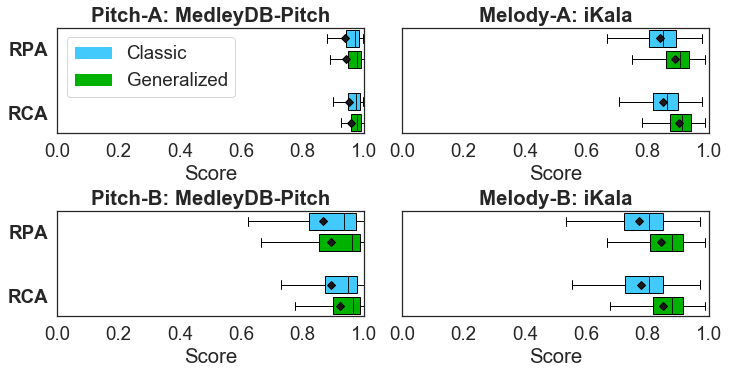

In [54]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.7)
sns.set_style('white')
# metric_vals = ["Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy",
#            "Voicing Recall", "Voicing False Alarm"]
metric_vals = ["Raw Pitch Accuracy", "Raw Chroma Accuracy"]
metric_vals = metric_vals[::-1]

df_crepe, n_groups_crepe = plot.get_dfbox([df_new_crepe, df_old_crepe], metric_vals)
df_melodia, n_groups_melodia = plot.get_dfbox([df_new_melodia, df_old_melodia], metric_vals)
df_pyin, n_groups_pyin = plot.get_dfbox([df_new_pyin, df_old_pyin], metric_vals)
df_deepsal, n_groups_deepsal = plot.get_dfbox([df_new_deepsal, df_old_deepsal], metric_vals)

plot.add_plot(221, ['RCA', 'RPA'], df_crepe, n_groups_crepe, 'Pitch-A: MedleyDB-Pitch', xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=['Generalized', 'Classic'])
plot.add_plot(222, metric_vals, df_deepsal, n_groups_deepsal, 'Melody-A: iKala',
              show_yaxis=False, xlim=[0.0, 1.0])#,
              #legend_loc=0, legend_labels=['Proposed', 'Existing'])
plot.add_plot(223, ['RCA', 'RPA'], df_pyin, n_groups_pyin, 'Pitch-B: MedleyDB-Pitch', xlim=[0.0, 1.0])#,
              #legend_loc=0, legend_labels=['Proposed', 'Existing'])
plot.add_plot(224, metric_vals, df_melodia, n_groups_melodia, 'Melody-B: iKala',
              show_yaxis=False, xlim=[0.0, 1.0])#,
              #legend_loc=0, legend_labels=['Proposed', 'Existing'])
plt.tight_layout(pad=0.0, w_pad=0.1, h_pad=0.3)
plt.savefig("../paper-figs/new_vs_old_by_algorithm.pdf", fmt='pdf', bbox_inches="tight")

# 5.2 Experiments - Threshold Grid

In [13]:
def get_scores_by_threshold(algorithm, dataset, binary_ref=False):
    
    scores_new = {}
    scores_mireval = {}
    thresholds = np.arange(0, 1.1, 0.1)
    for i in thresholds:
        scores_mireval[i] = {}    
    
    print(dataset)
    if dataset == 'ikala':
        data = mirdata.ikala.load()
    elif dataset == 'medleydb-pitch':
        data = mirdata.medleydb_pitch.load()
    elif dataset == 'medleydb-melody':
        data = mirdata.medleydb_melody.load()
    elif dataset == 'orchset':
        data = mirdata.orchset.load()
    else:
        raise ValueError("invalid dataset")

    for tid, track_data in data.items():
        if tid in SKIP:
            continue

        if dataset == 'ikala':
            ref_times = track_data.f0.times
            ref_freqs = track_data.f0.frequencies
            ref_conf = confidence.ikala(tid)
        elif dataset == 'medleydb-pitch':
            ref_times = track_data.pitch.times
            ref_freqs = track_data.pitch.frequencies
            ref_conf = confidence.medleydb_pitch(tid)
        elif dataset == 'medleydb-melody':
            ref_times = track_data.melody2.times
            ref_freqs = track_data.melody2.frequencies
            ref_conf = (ref_freqs > 0).astype(float)
        elif dataset == 'orchset':
            ref_times = track_data.melody.times
            ref_freqs = track_data.melody.frequencies
            ref_conf = (ref_freqs > 0).astype(float)

        if binary_ref:
            ref_conf = (ref_freqs > 0).astype(float)

        if algorithm == 'deepsalience':
            est_times, est_freqs, est_conf = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])
        elif algorithm == 'melodia':
            est_times, est_freqs, est_conf = outputs.load_melodia(outputs.MELODIA[tid])
        elif algorithm == 'crepe':
            est_times, est_freqs, est_conf = outputs.load_crepe(outputs.CREPE[tid])
        elif algorithm == 'pyin':
            est_times, est_freqs, est_conf = outputs.load_pyin(outputs.PYIN[tid])
        else:
            raise ValueError("invalid algorithm")

        for i in thresholds:
            scores_mireval[i][tid] = metrics.evaluate(
                ref_times, ref_freqs, (ref_freqs > 0).astype(float),
                est_times, est_freqs, (est_conf > i).astype(float))
#             est_freqs_multiplier = np.ones(est_freqs.shape)
#             est_freqs_multiplier[est_conf < i] = -1.0
#             scores_mireval[i][tid] = mir_eval.melody.evaluate(
#                 ref_times, ref_freqs, est_times, est_freqs*est_freqs_multiplier)

        scores_new[tid] = metrics.evaluate(ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)

    return scores_new, scores_mireval

In [14]:
scores_new_melodia_ikala, scores_mireval_melodia_ikala = get_scores_by_threshold('melodia', 'ikala')
scores_new_deepsal_ikala, scores_mireval_deepsal_ikala = get_scores_by_threshold('deepsalience', 'ikala')

ikala
ikala


In [15]:
scores_new_melodia_ikala_bin, scores_mireval_melodia_ikala_bin = get_scores_by_threshold(
    'melodia', 'ikala', binary_ref=True)
scores_new_deepsal_ikala_bin, scores_mireval_deepsal_ikala_bin = get_scores_by_threshold(
    'deepsalience', 'ikala', binary_ref=True)

ikala
ikala


In [16]:
scores_new_melodia_mdbmel, scores_mireval_melodia_mdbmel = get_scores_by_threshold('melodia', 'medleydb-melody')
scores_new_deepsal_mdbmel, scores_mireval_deepsal_mdbmel = get_scores_by_threshold('deepsalience', 'medleydb-melody')

medleydb-melody
medleydb-melody


In [17]:
scores_new_melodia_orchset, scores_mireval_melodia_orchset = get_scores_by_threshold('melodia', 'orchset')
scores_new_deepsal_orchset, scores_mireval_deepsal_orchset = get_scores_by_threshold('deepsalience', 'orchset')

orchset
orchset


In [18]:
def comparison_matrix(scores1, scores2, metric):
    th1 = scores1.keys()
    th2 = scores2.keys()
    avg1, avg2 = {}, {}
    for th in th1:
        avg1[th] = np.average([s[metric] for s in scores1[th].values()])
    for th in th2:
        avg2[th] = np.average([s[metric] for s in scores2[th].values()])

    comparison = np.zeros((len(th1), len(th2)))
    for i, thresh1 in enumerate(sorted(th1)):
        for j, thresh2 in enumerate(sorted(th2)):
            comparison[i, j] = avg1[thresh1] - avg2[thresh2]
    return comparison, avg1, avg2

In [19]:
comp_ikala, sweep_mel_ikala, sweep_ds_ikala = comparison_matrix(
    scores_mireval_melodia_ikala, scores_mireval_deepsal_ikala, 'Overall Accuracy')
comp_mdbmel, sweep_mel_mdbmel, sweep_ds_mdbmel = comparison_matrix(
    scores_mireval_melodia_mdbmel, scores_mireval_deepsal_mdbmel, 'Overall Accuracy')
comp_orchset, sweep_mel_orchset, sweep_ds_orchset = comparison_matrix(
    scores_mireval_melodia_orchset, scores_mireval_deepsal_orchset, 'Overall Accuracy')

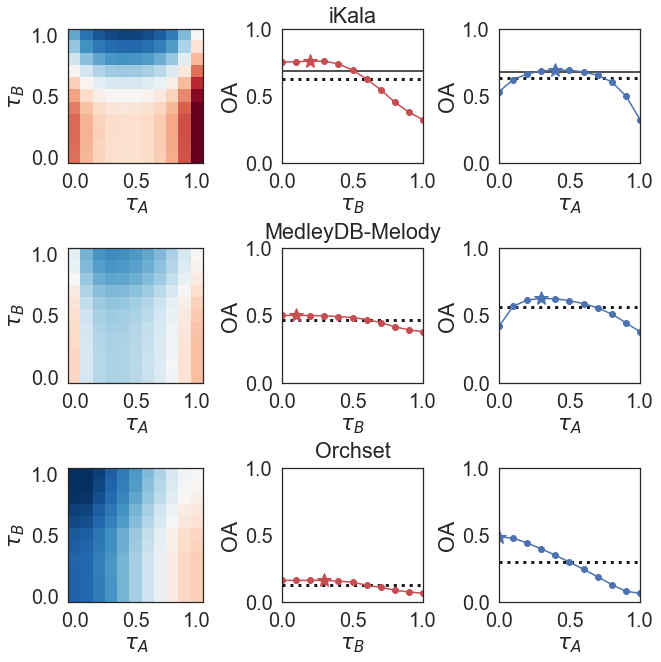

In [52]:
ticks_x = np.arange(0, 11, 5)
ticks_y = np.round(np.arange(0, 1.1, 0.1), 1)[::5]

plt.figure(figsize=(9, 9))
sns.set(font_scale=1.8)
sns.set_style('white')
plt.subplot(331)
plt.imshow(comp_ikala, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_B$")
plt.xlabel("$τ_A$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(332)
plt.title("iKala")
x = sorted(sweep_mel_ikala.keys())
y = [sweep_mel_ikala[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_ikala.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_ikala_bin.values()])
plt.plot([0, 1], [v1, v1], '-k')
plt.plot([0, 1], [v2, v2], ':k', linewidth=3)
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_B$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(333)
x = sorted(sweep_ds_ikala.keys())
y = [sweep_ds_ikala[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_ikala.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_ikala_bin.values()])
plt.plot([0, 1], [v1, v1], '-k')
plt.plot([0, 1], [v2, v2], ':k', linewidth=3)
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_A$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(334)
plt.imshow(comp_mdbmel, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_B$")
plt.xlabel("$τ_A$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(335)
plt.title("MedleyDB-Melody", pad=10)
x = sorted(sweep_mel_mdbmel.keys())
y = [sweep_mel_mdbmel[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_mdbmel.values()])
plt.plot([0, 1], [v2, v2], ':k', linewidth=3)
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_B$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(336)
x = sorted(sweep_ds_mdbmel.keys())
y = [sweep_ds_mdbmel[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_mdbmel.values()])
plt.plot([0, 1], [v2, v2], ':k', linewidth=3)
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_A$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)


plt.subplot(337)
plt.imshow(comp_orchset, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_B$")
plt.xlabel("$τ_A$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(338)
plt.title("Orchset", pad=10)
x = sorted(sweep_mel_orchset.keys())
y = [sweep_mel_orchset[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_melodia_orchset.values()])
plt.plot([0, 1], [v2, v2], ':k', linewidth=3)
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_B$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(339)
x = sorted(sweep_ds_orchset.keys())
y = [sweep_ds_orchset[i] for i in x]
v2 = np.average([t['Overall Accuracy'] for t in scores_new_deepsal_orchset.values()])
plt.plot([0, 1], [v2, v2], ':k', linewidth=3)
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_A$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.3)
plt.savefig("../paper-figs/grid_comparisons_melody.pdf", fmt='pdf', bbox_inches="tight")

### threshold plots for VFA, and VR

In [24]:
_, sweep_mel_ikala_vr, sweep_ds_ikala_vr = comparison_matrix(
    scores_mireval_melodia_ikala, scores_mireval_deepsal_ikala, 'Voicing Recall')
_, sweep_mel_mdbmel_vr, sweep_ds_mdbmel_vr = comparison_matrix(
    scores_mireval_melodia_mdbmel, scores_mireval_deepsal_mdbmel, 'Voicing Recall')
_, sweep_mel_orchset_vr, sweep_ds_orchset_vr = comparison_matrix(
    scores_mireval_melodia_orchset, scores_mireval_deepsal_orchset, 'Voicing Recall')

_, sweep_mel_ikala_vfa, sweep_ds_ikala_vfa = comparison_matrix(
    scores_mireval_melodia_ikala, scores_mireval_deepsal_ikala, 'Voicing False Alarm')
_, sweep_mel_mdbmel_vfa, sweep_ds_mdbmel_vfa = comparison_matrix(
    scores_mireval_melodia_mdbmel, scores_mireval_deepsal_mdbmel, 'Voicing False Alarm')
_, sweep_mel_orchset_vfa, sweep_ds_orchset_vfa = comparison_matrix(
    scores_mireval_melodia_orchset, scores_mireval_deepsal_orchset, 'Voicing False Alarm')

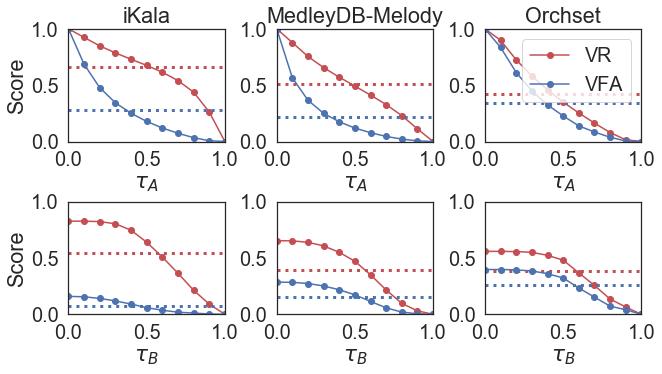

In [82]:
ticks_x = np.arange(0, 11, 5)
ticks_y = np.round(np.arange(0, 1.1, 0.1), 1)[::5]

# row is algorithm (x2, melodia, deep sal)
# col is dataset (x3, ikala, mdbmel, orchset)


plt.figure(figsize=(9, 5))
sns.set(font_scale=1.8)
sns.set_style('white')


plt.subplot(234)
# ikala, melodia
# plt.title("iKala")
x1 = sorted(sweep_mel_ikala_vr.keys())
y1 = [sweep_mel_ikala_vr[i] for i in x1]
v11 = np.average([t['Voicing Recall'] for t in scores_new_melodia_ikala.values()])
v12 = np.average([t['Voicing Recall'] for t in scores_new_melodia_ikala_bin.values()])
# plt.plot([0, 1], [v11, v11], '-r')
plt.plot([0, 1], [v12, v12], ':r', linewidth=3)
plt.plot(x1, y1, '-or')
# plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_mel_ikala_vfa.keys())
y2 = [sweep_mel_ikala_vfa[i] for i in x2]
v21 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_ikala.values()])
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_ikala_bin.values()])
# plt.plot([0, 1], [v21, v21], '-b')
plt.plot([0, 1], [v22, v22], ':b', linewidth=3)
plt.plot(x2, y2, '-ob')
# plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_B$")
plt.ylabel("Score")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(235)
# mdbmel, melodia
# plt.title("Melody Algorithm B \n")
x1 = sorted(sweep_mel_mdbmel_vr.keys())
y1 = [sweep_mel_mdbmel_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_melodia_mdbmel.values()])
plt.plot([0, 1], [v12, v12], ':r', linewidth=3)
plt.plot(x1, y1, '-or')
# plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_mel_mdbmel_vfa.keys())
y2 = [sweep_mel_mdbmel_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_mdbmel.values()])
plt.plot([0, 1], [v22, v22], ':b', linewidth=3)
plt.plot(x2, y2, '-ob')
# plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_B$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(236)
# orchset, melodia
x1 = sorted(sweep_mel_orchset_vr.keys())
y1 = [sweep_mel_orchset_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_melodia_orchset.values()])
plt.plot([0, 1], [v12, v12], ':r', linewidth=3)
plt.plot(x1, y1, '-or', label='VR')
# plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_mel_orchset_vfa.keys())
y2 = [sweep_mel_orchset_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_melodia_orchset.values()])
plt.plot([0, 1], [v22, v22], ':b', linewidth=3)
plt.plot(x2, y2, '-ob', label='VFA')
# plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_B$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)
# plt.legend(loc=0)#, ncol=2)

plt.subplot(231)
# ikala, deepsal
plt.title("iKala")
x1 = sorted(sweep_ds_ikala_vr.keys())
y1 = [sweep_ds_ikala_vr[i] for i in x1]
v11 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_ikala.values()])
v12 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_ikala_bin.values()])
# plt.plot([0, 1], [v11, v11], '-r')
plt.plot([0, 1], [v12, v12], ':r', linewidth=3)
plt.plot(x1, y1, '-or')
# plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_ds_ikala_vfa.keys())
y2 = [sweep_ds_ikala_vfa[i] for i in x2]
v21 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_ikala.values()])
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_ikala_bin.values()])
# plt.plot([0, 1], [v21, v21], '-b')
plt.plot([0, 1], [v22, v22], ':b', linewidth=3)
plt.plot(x2, y2, '-ob')
# plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_A$")
plt.ylabel("Score")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(232)
# mdbmel, deepsal
plt.title("MedleyDB-Melody")
x1 = sorted(sweep_ds_mdbmel_vr.keys())
y1 = [sweep_ds_mdbmel_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_mdbmel.values()])
plt.plot([0, 1], [v12, v12], ':r', linewidth=3)
plt.plot(x1, y1, '-or')
# plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_ds_mdbmel_vfa.keys())
y2 = [sweep_ds_mdbmel_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_mdbmel.values()])
plt.plot([0, 1], [v22, v22], ':b', linewidth=3)
plt.plot(x2, y2, '-ob')
# plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_A$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(233)
# orchset, deepsal
plt.title("Orchset")
x1 = sorted(sweep_ds_orchset_vr.keys())
y1 = [sweep_ds_orchset_vr[i] for i in x1]
v12 = np.average([t['Voicing Recall'] for t in scores_new_deepsal_orchset.values()])
plt.plot([0, 1], [v12, v12], ':r', linewidth=3)
plt.plot(x1, y1, '-or', label='VR')
# plt.plot(x1[np.argmax(y1)], np.max(y1), '*r', markersize=15)
x2 = sorted(sweep_ds_orchset_vfa.keys())
y2 = [sweep_ds_orchset_vfa[i] for i in x2]
v22 = np.average([t['Voicing False Alarm'] for t in scores_new_deepsal_orchset.values()])
plt.plot([0, 1], [v22, v22], ':b', linewidth=3)
plt.plot(x2, y2, '-ob', label='VFA')
# plt.plot(x2[np.argmax(y2)], np.max(y2), '*b', markersize=15)
plt.xlabel("$τ_A$")
# plt.ylabel("Score - Melodia")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)
plt.legend(loc=0)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.savefig("../paper-figs/thresh_plots_voicing.pdf", fmt='pdf', bbox_inches="tight")

### Pitch

In [34]:
scores_new_crepe, scores_mireval_crepe = get_scores_by_threshold('crepe', 'medleydb-pitch')
scores_new_pyin, scores_mireval_pyin = get_scores_by_threshold('pyin', 'medleydb-pitch')

medleydb-pitch
medleydb-pitch


In [35]:
scores_new_crepe_bin, _ = get_scores_by_threshold('crepe', 'medleydb-pitch', binary_ref=True)
scores_new_pyin_bin, _ = get_scores_by_threshold('pyin', 'medleydb-pitch', binary_ref=True)

medleydb-pitch
medleydb-pitch


In [36]:
comp_mdbpitch, sweep_pyin_mdbpitch, sweep_crepe_mdbpitch = comparison_matrix(
    scores_mireval_pyin, scores_mireval_crepe, 'Overall Accuracy')

comp_mdbpitch, sweep_pyin_mdbpitch, sweep_crepe_mdbpitch = comparison_matrix(
    scores_mireval_pyin, scores_mireval_crepe, 'Overall Accuracy')

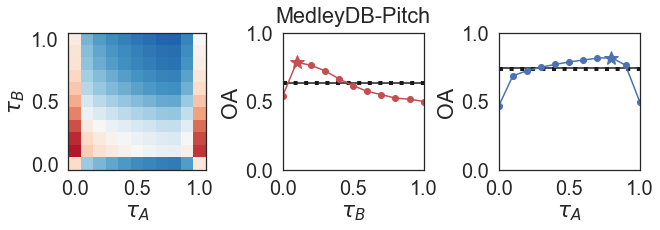

In [48]:
ticks_x = np.arange(0, 11, 5)
ticks_y = np.round(np.arange(0, 1.1, 0.1), 1)[::5]

plt.figure(figsize=(9, 3))
sns.set(font_scale=1.8)
sns.set_style('white')

plt.subplot(131)
plt.imshow(comp_mdbpitch, origin='lower', cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.ylabel("$τ_B$")
plt.xlabel("$τ_A$")
plt.xticks(ticks_x, ticks_y)
plt.yticks(ticks_x, ticks_y)
# plt.colorbar()

plt.subplot(132)
plt.title("MedleyDB-Pitch", pad=10)
x = sorted(sweep_pyin_mdbpitch.keys())
y = [sweep_pyin_mdbpitch[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_pyin.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_pyin_bin.values()])
plt.plot([0, 1], [v1, v1], '-k')
plt.plot([0, 1], [v2, v2], ':k', linewidth=4)
plt.plot(x, y, '-or')
plt.plot(x[np.argmax(y)], np.max(y), '*r', markersize=15)
plt.xlabel("$τ_B$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.subplot(133)
x = sorted(sweep_crepe_mdbpitch.keys())
y = [sweep_crepe_mdbpitch[i] for i in x]
v1 = np.average([t['Overall Accuracy'] for t in scores_new_crepe.values()])
v2 = np.average([t['Overall Accuracy'] for t in scores_new_crepe_bin.values()])
plt.plot([0, 1], [v1, v1], '-k')
plt.plot([0, 1], [v2, v2], ':k', linewidth=4)
plt.plot(x, y, '-ob')
plt.plot(x[np.argmax(y)], np.max(y), '*b', markersize=15)
plt.xlabel("$τ_A$")
plt.ylabel("OA")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xticks(ticks_y)
plt.yticks(ticks_y)

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.3)
plt.savefig("../paper-figs/grid_comparisons_pitch.pdf", fmt='pdf', bbox_inches="tight")

# 5.4 New metric - mixed binary and continuous reference and estimate


In [21]:
def get_mixed_results(threshold=0.5):
    scores_mireval = {}

    scores_bin_ref_bin_est = {}
    scores_bin_ref_cnt_est = {}
    scores_cnt_ref_bin_est = {}
    scores_cnt_ref_cnt_est = {}

    data = mirdata.ikala.load()

    for tid, track_data in data.items():
        if tid in SKIP:
            continue
        
        ref_times = track_data.f0.times
        ref_freqs = track_data.f0.frequencies
        ref_conf = confidence.ikala(tid)
        ref_conf_bin = (ref_freqs > 0).astype(float)

        est_times, est_freqs, est_conf = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])
        est_conf_bin = (est_conf > threshold).astype(float)
        
        est_freqs_multiplier = np.ones(est_freqs.shape)
        est_freqs_multiplier[est_conf < threshold] = -1.0

        scores_bin_ref_bin_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_bin, est_times, est_freqs, est_conf_bin)
        scores_bin_ref_cnt_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_bin, est_times, est_freqs, est_conf)
        scores_cnt_ref_bin_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf_bin)
        scores_cnt_ref_cnt_est[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)

        scores_mireval[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_bin,
            est_times, est_freqs, est_conf_bin)
#         scores_mireval[tid] = mir_eval.melody.evaluate(
#             ref_times, ref_freqs, est_times, est_freqs*est_freqs_multiplier)

    return (scores_mireval,
            scores_bin_ref_bin_est, scores_bin_ref_cnt_est,
            scores_cnt_ref_bin_est, scores_cnt_ref_cnt_est
        )

In [22]:
s_mireval, s_br_be, s_br_ce, s_cr_be, s_cr_ce = get_mixed_results()

In [23]:
df_mireval = pd.DataFrame.from_dict(s_mireval, orient='index')
df_br_be = pd.DataFrame.from_dict(s_br_be, orient='index')
df_br_ce = pd.DataFrame.from_dict(s_br_ce, orient='index')
df_cr_be = pd.DataFrame.from_dict(s_cr_be, orient='index')
df_cr_ce = pd.DataFrame.from_dict(s_cr_ce, orient='index')

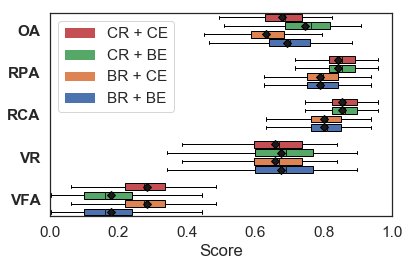

In [24]:
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.4)
sns.set_style('white')
metric_vals = ["Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy",
           "Voicing Recall", "Voicing False Alarm"]
metric_vals = metric_vals[::-1]

df_grid, n_groups_grid = plot.get_dfbox(
    [df_br_be, df_br_ce, df_cr_be, df_cr_ce], metric_vals)

plot.add_plot(111, ['OA', 'RPA', 'RCA', 'VR', 'VFA'][::-1], df_grid, n_groups_grid, '', xlim=[0.0, 1.0],
              legend_loc=0, legend_labels=[
                  'BR + BE',
                  'BR + CE',
                  'CR + BE',
                  'CR + CE'
              ], colors=sns.color_palette(n_colors=4))

plt.tight_layout()
plt.savefig("../paper-figs/binary-continuous-grid.pdf", fmt='pdf', bbox_inches="tight")

# 4a - Qualitative Example of voicing disagreement with reference

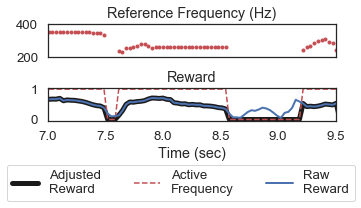

In [83]:
def temp_ikala(track_id, source_sep=False):

    if source_sep:
        confidence_fpath = os.path.join(
            "../experiments/separation_confidence",
            "iKala", "{}_VUIMM.wav.conf.csv".format(track_id))
    else:
        confidence_fpath = (
            "../experiments/confidence/iKala/{}.wav.conf.csv".format(track_id))

    with open(confidence_fpath, 'r') as fhandle:
        reader = csv.reader(fhandle, delimiter=',')
        raw_times, raw_conf = [], []

        for line in reader:
            raw_times.append(float(line[0]))
            raw_conf.append(float(line[1]))

    track_data = mirdata.ikala.load_track(track_id)

    conf = scipy.interpolate.interp1d(
        np.array(raw_times), np.array(raw_conf),
        'linear', fill_value=0.0, bounds_error=False)(track_data.f0.times)

#     conf = conf * (track_data.f0.frequencies > 0).astype('float')

    return conf

for tid in mirdata.ikala.track_ids():
    track_data = mirdata.ikala.load_track(tid)
    ref_times = track_data.f0.times
    ref_freqs = track_data.f0.frequencies
    ref_conf = temp_ikala(tid)

    fig = plt.figure(figsize=(5, 3))
    sns.set(font_scale=1.2)
    sns.set_style('white')
    ax = plt.subplot(211)
#     plt.title("Frequency")
    plt.plot(ref_times, ref_freqs, '.r')
    plt.xlim([7, 9.5])
    plt.ylim([200, 400])
    plt.xticks([], [])
    plt.title("Reference Frequency (Hz)")
    plt.subplot(212)
#     plt.title("Estimated Confidence")
    plt.plot(ref_times, ref_conf * (ref_freqs > 0).astype('float'), '-k', linewidth=5, label='Adjusted\nReward')
    plt.plot(ref_times, (ref_freqs > 0).astype(float), '--r', label='Active\nFrequency')
    plt.plot(ref_times, ref_conf, '-b', linewidth=2, label='Raw\nReward')
    plt.xlim([7, 9.5])
    plt.title("Reward")
    plt.xlabel("Time (sec)")
    plt.tight_layout()
    
    fig.legend(ncol=3, loc=3, mode='expand')

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.4)

    plt.savefig("../paper-figs/confidence_ex.pdf", fmt='pdf', bbox_inches="tight")
    break

# 4b - Compare SS confidence vs RMS confidence ikala Deep Salience

In [57]:
def get_ikala_conf_scores():

    scores_rms_conf_d = {}
    scores_ss_conf_d = {}
    scores_rms_conf_m = {}
    scores_ss_conf_m = {}
    
    data = mirdata.ikala.load()

    for tid, track_data in data.items():
        if tid in SKIP:
            continue
        
        ref_times = track_data.f0.times + (0.032/2.0)
        ref_freqs = track_data.f0.frequencies
        ref_conf = confidence.ikala(tid)
        ref_conf_ss = confidence.ikala(tid, source_sep=True)

        est_times_ds, est_freqs_ds, est_conf_ds = outputs.load_deepsalience(outputs.DEEP_SALIENCE[tid])
        est_times_m, est_freqs_m, est_conf_m = outputs.load_melodia(outputs.MELODIA[tid])

        scores_rms_conf_d[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf, est_times_ds, est_freqs_ds, est_conf_ds)
        scores_ss_conf_d[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_ss, est_times_ds, est_freqs_ds, est_conf_ds)
        
        scores_rms_conf_m[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf, est_times_m, est_freqs_m, est_conf_m)
        scores_ss_conf_m[tid] = metrics.evaluate(
            ref_times, ref_freqs, ref_conf_ss, est_times_m, est_freqs_m, est_conf_m)
        
    return scores_rms_conf_d, scores_ss_conf_d, scores_rms_conf_m, scores_ss_conf_m

In [58]:
(scores_rms_conf_d, scores_ss_conf_d,
 scores_rms_conf_m, scores_ss_conf_m) = get_ikala_conf_scores()

In [59]:
data = mirdata.ikala.load()
for tid, track_data in data.items():
    if tid in SKIP:
        continue

    ref_times = track_data.f0.times
    ref_freqs = track_data.f0.frequencies
    ref_conf = confidence.ikala(tid)
    ref_conf_ss = confidence.ikala(tid, source_sep=True)
    break

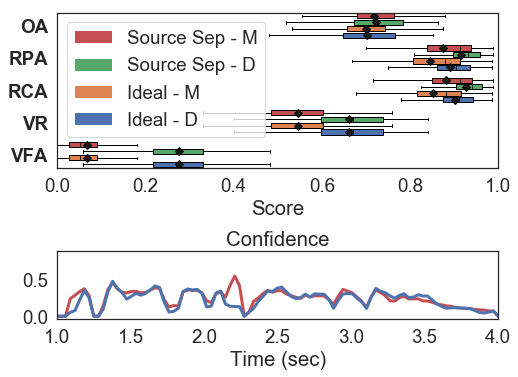

In [60]:
df_rms_d = pd.DataFrame.from_dict(scores_rms_conf_d, orient='index')
df_ss_d = pd.DataFrame.from_dict(scores_ss_conf_d, orient='index')
df_rms_m = pd.DataFrame.from_dict(scores_rms_conf_m, orient='index')
df_ss_m = pd.DataFrame.from_dict(scores_ss_conf_m, orient='index')

plt.figure(figsize=(7, 6))
sns.set(font_scale=1.7)
sns.set_style('white')
metric_vals = ["Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy",
           "Voicing Recall", "Voicing False Alarm"]
metric_vals = metric_vals[::-1]

df_ss_exp, n_groups_ss = plot.get_dfbox([df_rms_d, df_rms_m, df_ss_d, df_ss_m], metric_vals)

plot.add_plot(211, ['VFA', 'VR', 'RCA', 'RPA', 'OA'], df_ss_exp, n_groups_ss,
              '', xlim=[0.0, 1.0],
              legend_loc=0,
              legend_labels=['Ideal - D', 'Ideal - M', 'Source Sep - D', 'Source Sep - M'],
              colors=sns.color_palette(n_colors=4))

plt.subplot(413)
plt.plot(ref_times, ref_conf, 'r', label="Ideal", linewidth=3)
plt.plot(ref_times, ref_conf_ss, 'b', label="Source Sep", linewidth=3)
plt.xlabel("Time (sec)")
plt.title("Confidence")
# plt.legend()
plt.xlim([1, 4])

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-1)
plt.savefig("../paper-figs/ss_vs_rms.pdf", fmt='pdf', bbox_inches="tight")

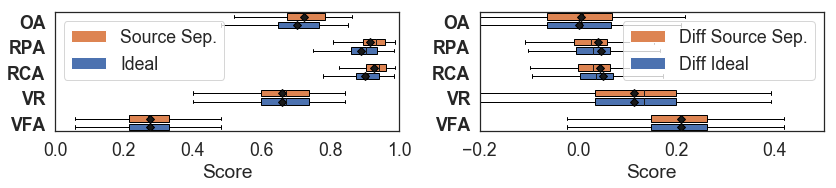

In [79]:
df_rms_d = pd.DataFrame.from_dict(scores_rms_conf_d, orient='index')
df_ss_d = pd.DataFrame.from_dict(scores_ss_conf_d, orient='index')
df_rms_m = pd.DataFrame.from_dict(scores_rms_conf_m, orient='index')
df_ss_m = pd.DataFrame.from_dict(scores_ss_conf_m, orient='index')

plt.figure(figsize=(12, 3))
sns.set(font_scale=1.6)
sns.set_style('white')
metric_vals = ["Overall Accuracy", "Raw Pitch Accuracy", "Raw Chroma Accuracy",
           "Voicing Recall", "Voicing False Alarm"]
metric_vals = metric_vals[::-1]

df_ss_exp, n_groups_ss = plot.get_dfbox([df_rms_d - df_rms_m,df_ss_d - df_ss_m], metric_vals)

plot.add_plot(122, ['VFA', 'VR', 'RCA', 'RPA', 'OA'], df_ss_exp, n_groups_ss,
              '', xlim=[-0.2, 0.5],
              legend_loc=0,
              legend_labels=['Diff Ideal', 'Diff Source Sep.'],
              colors=sns.color_palette(n_colors=4))

df_ss_exp, n_groups_ss = plot.get_dfbox([df_rms_d, df_ss_d], metric_vals)

plot.add_plot(121, ['VFA', 'VR', 'RCA', 'RPA', 'OA'], df_ss_exp, n_groups_ss,
              '', xlim=[0.0, 1.0],
              legend_loc=0,
              legend_labels=['Ideal', 'Source Sep.'],
              colors=sns.color_palette(n_colors=4))

# plt.subplot(413)
# plt.plot(ref_times, ref_conf, 'r', label="Ideal", linewidth=3)
# plt.plot(ref_times, ref_conf_ss, 'b', label="Source Sep", linewidth=3)
# plt.xlabel("Time (sec)")
# plt.title("Confidence")
# # plt.legend()
# plt.xlim([1, 4])
plt.tight_layout()
# plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-1)
plt.savefig("../paper-figs/ss_vs_rms_diff.pdf", fmt='pdf', bbox_inches="tight")

In [30]:
from scipy.stats import ttest_rel

In [33]:
# for m in metric_vals:
#     print(m)
#     print(ttest_rel(df_rms[m], df_ss[m]))
#     print("")

In [34]:
df_diff_rms = df_rms_d - df_rms_m
df_diff_ss = df_ss_d - df_ss_m

for m in metric_vals:
    print(m)
    diff_rms = [df_diff_rms[m][t] for t in sorted(df_diff_rms.index)]
    diff_ss = [df_diff_ss[m][t] for t in sorted(df_diff_rms.index)]
    print(ttest_rel(diff_rms, diff_ss))
    print("")

Raw Chroma Accuracy
Ttest_relResult(statistic=12.862800156747573, pvalue=2.0102501082154806e-29)

Raw Pitch Accuracy
Ttest_relResult(statistic=11.08646601620366, pvalue=1.646819007768616e-23)



In [35]:
[df_rms_d['Overall Accuracy'][t] for t in sorted(df_rms_d.index)]

[0.6291979978158397,
 0.6543500382014158,
 0.4944168312345298,
 0.7240787059886898,
 0.6928857315764374,
 0.6309864989588917,
 0.7317875970983134,
 0.7076612735979949,
 0.7030776716102722,
 0.6366331054433302,
 0.7126664573316912,
 0.7421923218765505,
 0.7878536131276049,
 0.766826269558905,
 0.6983393520686318,
 0.6514362478596808,
 0.7739588862551935,
 0.6768055308301906,
 0.7416283860288695,
 0.7693698007105505,
 0.6361533764429939,
 0.6869531124403077,
 0.5686978584519945,
 0.5955245415180291,
 0.5810333207012611,
 0.6587259587436566,
 0.7579550008642907,
 0.7511984592288533,
 0.6203368871205246,
 0.5938537925109284,
 0.7199051965986865,
 0.5477741040054062,
 0.6619844660476902,
 0.6582665483945892,
 0.5377442603436164,
 0.598521442932952,
 0.7559267395917654,
 0.6544740546296582,
 0.6102415761297807,
 0.7237408932741286,
 0.6655072703993014,
 0.806727551422987,
 0.7729911970221374,
 0.7682567960645518,
 0.667048350673443,
 0.7098590167981036,
 0.7366710571062394,
 0.60046825880486